In [18]:
import matplotlib.pyplot as plt

import data_containers as dc
import traj_planner as tj

from importlib import reload 
reload(dc)
reload(tj)

import utils.qgc_utils as qgc
import trajectory_io as io

reload(qgc)
reload(io)

<module 'trajectory_io' from '/home/alessandro/repos/drone_flightplans/trajectory_io.py'>

In [19]:
site=dc.Site("./coords/site.json")
site.set_origin()

planner = tj.TrajectoryPlanner(site)

In [20]:
poi_enu = site.geodetic_to_enu(site.origin)

trajectory = planner.new_arc_trajectory_202412(
    nominal_poi = poi_enu, #poi with respect to which we compute the center of the arc
    nominal_az= 90,
    nominal_el= 47,
    nominal_srange= 500,
    # actual POI with respect to which we move
    poi = site.geodetic_to_enu(site.compute_barycenter()),
    delta_el= 10,
    num_steps_el= 5,
)
trajectory.plot_boresight=True

In [21]:
rtk_correct_position=dc.Geodetic(lat=-22.95977498,
                           lon=-67.78669706,
                           alt=5182.214
                          )
rtk_broadcast_position=dc.Geodetic(lat=-22.9597732,
                           lon=-67.7866847,
                           alt=5173.020
                          )
"""
rtk_broadcast_position=dc.Geodetic(lat=-22.9598362,
                           lon=-67.7864538,
                           alt=5168.080
                          )
"""


'\nrtk_broadcast_position=dc.Geodetic(lat=-22.9598362,\n                           lon=-67.7864538,\n                           alt=5168.080\n                          )\n'

In [33]:
np.rad2deg(np.arcsin(1.5/500))

0.17188759637129902

In [17]:
import copy
def correct_RTK_base_offset(
    trajectory,
    rtk_correct_position,
    rtk_broadcast_position,
    site
    ):
    enu_rtk_correct = site.geodetic_to_enu(rtk_correct_position)
    enu_rtk_broadcast = site.geodetic_to_enu(rtk_broadcast_position)
    
    offset = enu_rtk_broadcast-enu_rtk_correct
    traj_corrected=copy.copy(trajectory)
    traj_corrected.enu=trajectory.enu-offset.as_array()
    traj_corrected.compute_geodetic(site)

    poi_corrected = site.geodetic_to_enu(trajectory.poi).as_array()-offset.as_array()
    poi_corrected = dc.ENU(poi_corrected[0],
                           poi_corrected[1],
                           poi_corrected[2],
                          )
    poi_corrected = site.enu_to_geodetic(poi_corrected)
    traj_corrected.poi=poi_corrected
    return traj_corrected
    
def compute_yawcorr_poi(yaw_correction,
                        site,
                        trajectory_arccenter_enu
                       ):
    vec_arc2poi_enu = site.geodetic_to_enu(trajectory.poi)-trajectory_arccenter_enu
    vec_arc2poi_yaw = np.array(pm.enu2aer(vec_arc2poi_enu.e,
                                          vec_arc2poi_enu.n, 
                                          vec_arc2poi_enu.u))
    newvec_arc2poi_yaw = copy.copy(vec_arc2poi_yaw)
    newvec_arc2poi_yaw[0] += yaw_correction
    newvec_arc2poi_enu = np.array(pm.aer2enu(newvec_arc2poi_yaw[0], newvec_arc2poi_yaw[1], newvec_arc2poi_yaw[2]))
    newpoi_enu = newvec_arc2poi_enu+trajectory_arccenter_enu.as_array()
    newpoi_enu = dc.ENU(newpoi_enu[0], newpoi_enu[1], newpoi_enu[2])
    
    return site.enu_to_geodetic(newpoi_enu)

In [50]:
#nominal flights
yaw_correction=+4.6
azs = [180]
els = [47, 53]#, 50, 53, 56]
srange=500
secs = ["top", "bott"]
pois = ["satp1"]

barycenter_enu = site.geodetic_to_enu(site.compute_barycenter())
for az in azs:
    for el in els:

        trajectories=[]
        for sec in secs:
            for poi_name in pois:

                if poi_name=="barycenter":
                    poi=barycenter_enu
                else:
                    poi = site.telescopes[poi_name].enu

                if sec =="full":
                    delta_el=10
                    el_shift=0
                elif sec=="mid":
                    delta_el=5
                    el_shift=0
                elif sec=="top":
                    delta_el=5
                    el_shift= 3.5
                elif sec=="bott":
                    delta_el=5
                    el_shift= -3.5
                
                trajectory = planner.new_arc_trajectory_202412(
                    nominal_poi = barycenter_enu, #poi with respect to which we compute the center of the arc
                    nominal_az= az,
                    nominal_el= el+el_shift,
                    nominal_srange= srange,
                    # actual POI with respect to which we move
                    poi = poi,
                    delta_el= delta_el,
                    num_steps_el= 6,
                )


                trajectory = correct_RTK_base_offset(trajectory,
                        rtk_correct_position,
                        rtk_broadcast_position,
                        site
                       )

                corr_poi = compute_yawcorr_poi(yaw_correction,
                        site,
                        trajectory.arccenter
                       )

                trajectory.poi=corr_poi
                
                if sec=="full" and poi_name=="barycenter":
                    trajectory.plot_boresight=True
                else:
                    trajectory.plot_boresight=False
                trajectories.append(trajectory)

                if az==180:
                    safety = "south"
                elif az==90:
                    safety = "east"

                dir_path="./outputs/2025_12/litchi/corrections"
                name = "2025_12_YAWCORR{:.1f}_{}_el{:d}_{}_{}".format( float(yaw_correction),safety.upper(), int(el), sec.upper(), poi_name.upper())
                
                #io.export_mission_qgc(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"qgc/nominal/"+name+".plan", safety_waypoints=safety, 
                #                      fence=True)
                io.export_mission_litchi(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"/"+name+".csv", safety_waypoints=safety,)
                #io.export_mission_mp(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"mp/nominal/"+name+".waypoints", safety_waypoints=safety)
        """
        planner.plot_trajectories(trajectories, 
                                  boresight_table=True,
                                  title="Nominal AZ: {:d}° Nominal EL: {:d}°".format(int(az), int(el)),
                                  save_path= dir_path+"/plots/nominal_az{:d}_el{:d}.pdf".format(int(az), int(el))
                                 )
        """
    

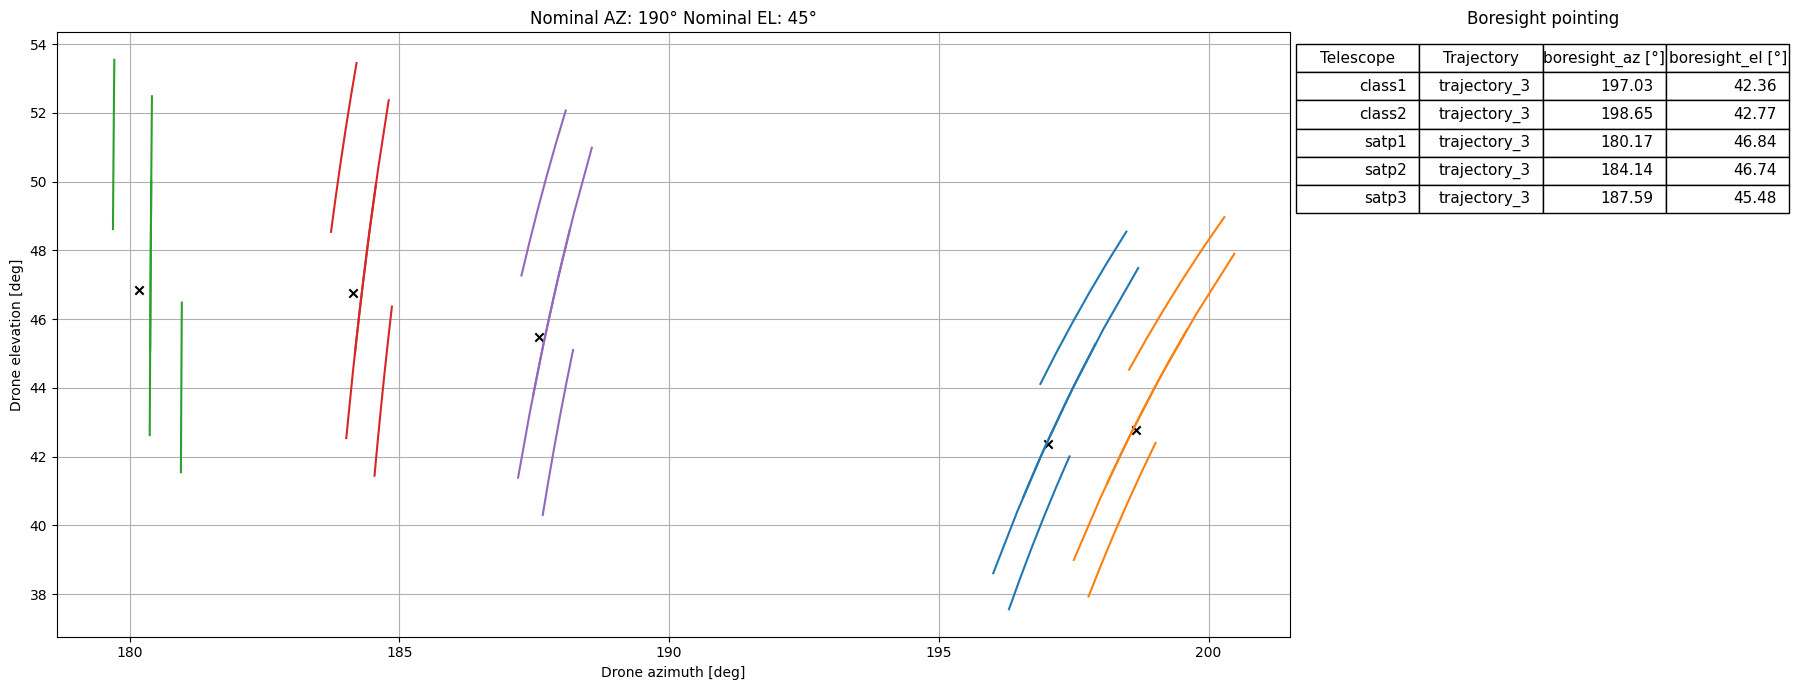

In [52]:
#nominal flights
yaw_correction=+4.6
azs = [180+10]
els = [45]#, 50, 53, 56]
srange=500
secs = ["mid", "top", "bott", "full"]
pois = ["satp1"]

barycenter_enu = site.geodetic_to_enu(site.compute_barycenter())
for az in azs:
    for el in els:

        trajectories=[]
        for sec in secs:
            for poi_name in pois:

                if poi_name=="barycenter":
                    poi=barycenter_enu
                else:
                    poi = site.telescopes[poi_name].enu

                if sec =="full":
                    delta_el=10
                    el_shift=0
                elif sec=="mid":
                    delta_el=5
                    el_shift=0
                elif sec=="top":
                    delta_el=5
                    el_shift= 3.5
                elif sec=="bott":
                    delta_el=5
                    el_shift= -3.5
                
                trajectory = planner.new_arc_trajectory_202412(
                    nominal_poi = barycenter_enu, #poi with respect to which we compute the center of the arc
                    nominal_az= az,
                    nominal_el= el+el_shift,
                    nominal_srange= srange,
                    # actual POI with respect to which we move
                    poi = poi,
                    delta_el= delta_el,
                    num_steps_el= 6,
                )

                
                trajectory = correct_RTK_base_offset(trajectory,
                        rtk_correct_position,
                        rtk_broadcast_position,
                        site
                       )

                corr_poi = compute_yawcorr_poi(yaw_correction,
                        site,
                        trajectory.arccenter
                       )

                trajectory.poi=corr_poi
                
                if sec=="full":# and poi_name=="barycenter":
                    trajectory.plot_boresight=True
                else:
                    trajectory.plot_boresight=False
                trajectories.append(trajectory)

                if 160<az<200:
                    safety = "south"
                elif az==90:
                    safety = "east"

                dir_path="./outputs/2025_12/litchi/corrections"
                name = "2025_12_YAWCORR{:.1f}_az{:d}_el{:d}_{}_{}".format( float(yaw_correction), az, int(el), sec.upper(), poi_name.upper())
                
                #io.export_mission_qgc(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"qgc/nominal/"+name+".plan", safety_waypoints=safety, 
                #                      fence=True)
                io.export_mission_litchi(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"/"+name+".csv", safety_waypoints=safety,)
                #io.export_mission_mp(trajectory, move_speed=10, scan_speed=1.5, n_repeat=9, savepath=dir_path+"mp/nominal/"+name+".waypoints", safety_waypoints=safety)
        
        planner.plot_trajectories(trajectories, 
                                  boresight_table=True,
                                  title="Nominal AZ: {:d}° Nominal EL: {:d}°".format(int(az), int(el)),
                                  save_path= None,#dir_path+"/plots/nominal_az{:d}_el{:d}.pdf".format(int(az), int(el))
                                 )
        
    

In [11]:
import numpy as np
import pymap3d as pm

In [14]:
yaw_correction=-14
arc2poi0_enu = site.geodetic_to_enu(trajectory.poi)-trajectory.arccenter
arc2poi0_yaw = np.array(pm.enu2aer(arc2poi0_enu.e, arc2poi0_enu.n, arc2poi0_enu.u))
arc2poi0_new_yaw = copy.copy(arc2poi0_yaw)
arc2poi0_new_yaw[0]+=yaw_correction

arc2poinew_enu = np.array(pm.aer2enu(arc2poi0_new_yaw[0], arc2poi0_new_yaw[1], arc2poi0_new_yaw[2]))
new_poi = arc2poinew_enu+trajectory.arccenter.as_array()

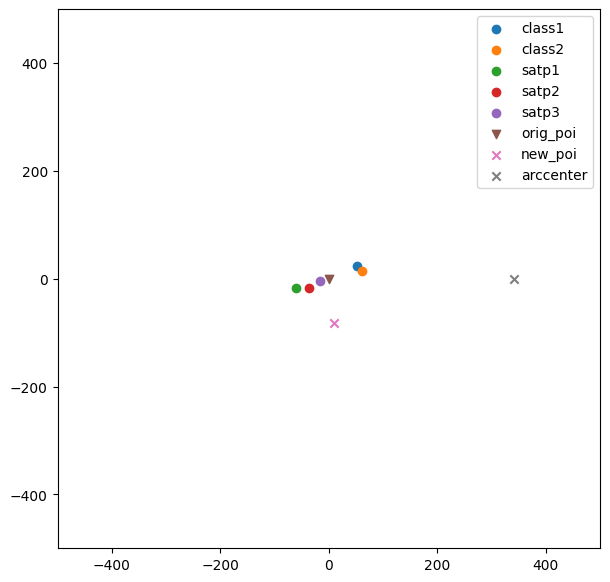

In [15]:
plt.figure(figsize=(7,7))
for tel_name in site.telescopes.keys():
    plt.scatter(site.telescopes[tel_name].enu.e, site.telescopes[tel_name].enu.n, label=tel_name)
size =500
plt.xlim(-size,size)
plt.ylim(-size,size)

plt.scatter(site.geodetic_to_enu(trajectory.poi).e, site.geodetic_to_enu(trajectory.poi).n, label="orig_poi", marker="v")
plt.scatter(new_poi[0], new_poi[1], label="new_poi", marker="x")
plt.scatter(trajectory.arccenter.e, trajectory.arccenter.n, label="arccenter", marker="x")
plt.legend()

In [146]:
trajectory.geodetic

array([[ -22.95991765,  -67.78433478, 5497.05636866],
       [ -22.95991998,  -67.78439443, 5504.2862045 ],
       [ -22.95992236,  -67.7844553 , 5511.40800056],
       [ -22.95992478,  -67.78451737, 5518.41958782],
       [ -22.95992726,  -67.78458061, 5525.31883086],
       [ -22.95992978,  -67.78464503, 5532.10362847]])

In [111]:
def compute_yawcorr_poi(yaw_correction,
                        site,
                        trajectory_arccenter_enu
                       ):
    vec_arc2poi_enu = site.geodetic_to_enu(trajectory.poi)-trajectory_arccenter_enu
    vec_arc2poi_yaw = np.array(pm.enu2aer(vec_arc2poi_enu.e,
                                          vec_arc2poi_enu.n, 
                                          vec_arc2poi_enu.u))
    newvec_arc2poi_yaw = copy.copy(vec_arc2poi_yaw)
    newvec_arc2poi_yaw[0] += yaw_correction
    newvec_arc2poi_enu = np.array(pm.aer2enu(newvec_arc2poi_yaw[0], newvec_arc2poi_yaw[1], newvec_arc2poi_yaw[2]))
    newpoi_enu = newvec_arc2poi_enu+trajectory_arccenter_enu.as_array()

    return newpoi_enu

new_poi = compute_yawcorr_poi(+8,
                    site,
                    trajectory.arccenter
                    )

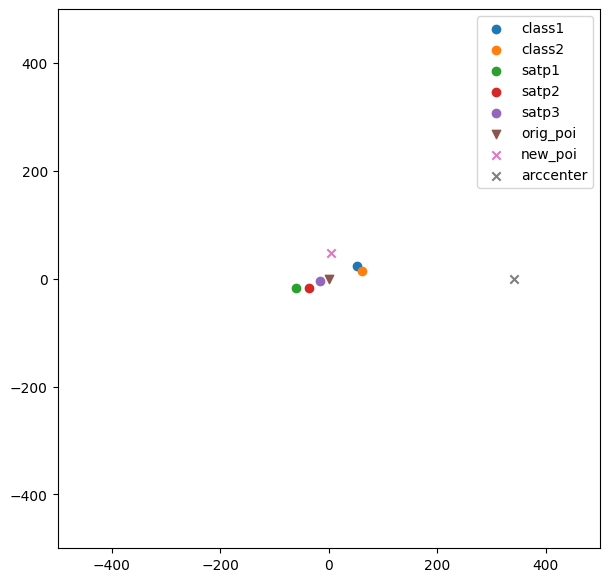

In [112]:
plt.figure(figsize=(7,7))
for tel_name in site.telescopes.keys():
    plt.scatter(site.telescopes[tel_name].enu.e, site.telescopes[tel_name].enu.n, label=tel_name)
size =500
plt.xlim(-size,size)
plt.ylim(-size,size)

plt.scatter(site.geodetic_to_enu(trajectory.poi).e, site.geodetic_to_enu(trajectory.poi).n, label="orig_poi", marker="v")
plt.scatter(new_poi[0], new_poi[1], label="new_poi", marker="x")
plt.scatter(trajectory.arccenter.e, trajectory.arccenter.n, label="arccenter", marker="x")
plt.legend()

In [49]:
trajectory.arccenter.e

340.9991800312493

In [32]:
arc2poinew_enu

array([337.68059945,  47.45791331, 365.67685081])

In [ ]:
def correct_POI_az_offset(
    trajectory,
    site,
    az_offset
):
    